In [41]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import time
from datetime import datetime
from pandas.api.types import CategoricalDtype
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [42]:
data = pd.read_csv('ks-projects-201801.csv', encoding = "ISO-8859-1")

In [43]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

In [44]:
data.nunique()
print(data.state.unique())

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']


In [45]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
usd pledged,3797,0.010027
name,4,0.000011
usd_goal_real,0,0.000000
usd_pledged_real,0,0.000000
country,0,0.000000
backers,0,0.000000
state,0,0.000000
pledged,0,0.000000
launched,0,0.000000
goal,0,0.000000


### Cleaning data 

In [46]:
data = data.drop(['ID', 'name'], axis = 1, errors = 'ignore') 
data = data.rename(index=str, columns={"state ": "state", "country ": "country"})

In [47]:
stateDataType = CategoricalDtype(categories=['failed','canceled','successful','live','undefined','suspended'], ordered=True)
data["state"] = data["state"].astype(stateDataType).cat.codes
data["country"] = data["country"].astype('category').cat.codes
data["currency"] = data["currency"].astype('category').cat.codes
data["main_category"] = data["main_category"].astype('category').cat.codes
data["category"] = data["category"].astype('category').cat.codes


In [48]:
#Conver datatipes to number  
data.launched = data.launched.map(lambda x: time.mktime(datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))
data.deadline = data.deadline.map(lambda x: time.mktime(datetime.strptime(x, "%Y-%m-%d").timetuple()))

In [49]:
#Solve the problem with missing values 
#Fill nil to mean
data.fillna(data.mean(), inplace=True)

#Fill median
# data.fillna(data.median(), inplace=True)



### Additional data EXPLORATION 

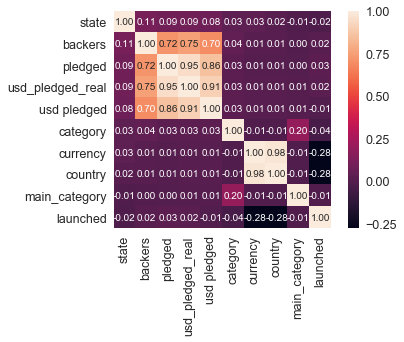

In [50]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = data.corr()
cols = corrmat.nlargest(k, 'state')['state'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Build DecisionTreeClassifier model 

In [51]:
 # Try to find best result for more depths of tree
def decisionTreeArgumentOptimalization(featurse, label):
    depths = range(1,20)
    acc = []
    RMSE = []
    count = 0
    for depth in depths:
        model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=depth)
        predicted = cross_val_predict(model, featurse, label, cv=4)
        acc.append(metrics.accuracy_score(label, predicted))
        RMSE.append(np.sqrt(metrics.mean_squared_error(label, predicted)))
        count += 1
        print("Progress {:2.1%}".format(count / len(depths)), end="\r")
        
    plt.figure(figsize=(5,5))
    plt.plot(acc,'ob-')
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.legend(['Accuracy'])


    plt.figure(figsize=(5,5))
    plt.plot(RMSE,'ob-')
    plt.xlabel('max_depth')
    plt.ylabel('RMSE')
    plt.legend(['RMSE'])
    

In [52]:
def decisionTree(featurse, label, depth):
    #Best model
    model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=depth)
    predicted = cross_val_predict(model, featurse, label, cv=4)

    print("[DecisionTree] Accuracy of the best configuration: " + str(metrics.accuracy_score(label, predicted)))
    print("[DecisionTree] RMSE of the best configuration: " + str(metrics.mean_squared_error(label, predicted)))

### Build RandomForest model 

In [53]:
def  randomForestArgumentOptimalization(featurse, label):
    # Try to find best result for more depths of tree
    depths = range(1,20,5)
    count_trees = range(1,800,400)
    max_features = range(1,10,5)
    acc = []
    RMSE = []
    count = 0
    for depth in depths:
        for n_est in count_trees:
            for max_f in max_features:
                model = RandomForestClassifier(n_estimators=n_est, max_features=max_f, max_depth=depth)
                predicted = cross_val_predict(model, featurse, label, cv=4)
                acc.append([metrics.accuracy_score(label, predicted), depth, n_est, max_f])
                RMSE.append([np.sqrt(metrics.mean_squared_error(label, predicted)), depth, n_est, max_f])
                count += 1
                print("Progress {:2.1%}".format(count / (len(depths)*len(count_trees)*len(max_features))), end="\r")
    
    acc.sort(key=lambda x: x[0], reverse=True)
    print(acc[0])

    RMSE.sort(key=lambda x: x[0], reverse=False)
    print(RMSE[0])

In [54]:
def gradientBoosting(featurse, label, m_depth=5, random_s=444 ):
    model = GradientBoostingClassifier(max_depth=m_depth, random_state=random_s)
    predicted = cross_val_predict(model, featurse, label, cv=5)
    print("[DecisionTree] Accuracy of the best configuration: " + str(metrics.accuracy_score(label, predicted)))
    print("[DecisionTree] RMSE of the best configuration: " + str(metrics.mean_squared_error(label, predicted)))

### Experiments

In [55]:
# Create label data and feratures data 
label = data.state
featurse = data.drop(['state', 'Id'], axis = 1, errors = 'ignore')

CPU times: user 3min 38s, sys: 4.57 s, total: 3min 43s
Wall time: 3min 48s


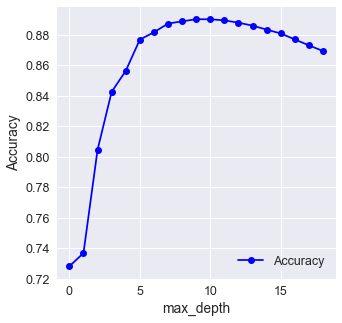

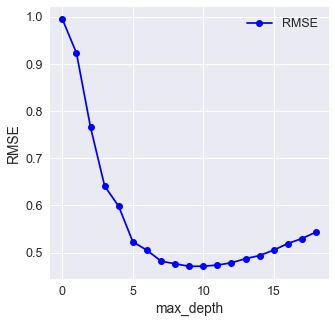

In [57]:
%%time
decisionTreeArgumentOptimalization(featurse, label)

In [58]:
%%time
randomForestArgumentOptimalization(featurse, label)

[0.8918055992035092, 16, 401, 6]
[0.46505118285086716, 16, 401, 6]
CPU times: user 1h 56min 23s, sys: 2min 30s, total: 1h 58min 53s
Wall time: 9h 58min 7s


In [59]:
%%time
gradientBoosting(featurse, label)

[DecisionTree] Accuracy of the best configuration: 0.8895951788010912
[DecisionTree] RMSE of the best configuration: 0.22894620782177197
CPU times: user 1h 1min 30s, sys: 1min 30s, total: 1h 3min 1s
Wall time: 1h 3min 44s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b528470>]],
      dtype=object)

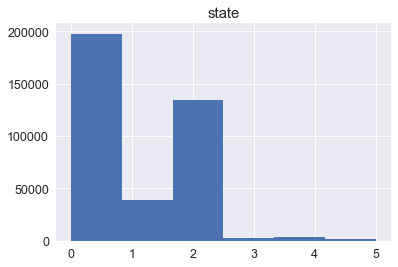

In [22]:
data.hist(column='state', bins=6)

In [26]:
# data.state[data.state == 4] = 0
# data.state[data.state == 1] = 0
data = data[data.state != 3]
data = data[data.state != 5]

We can split category 'canceled' and 'suspended' to category FILED. And remove data of category UNDEFINED and LIFE, becose it is importent data to use over model. We wan detect only success or not. 

In [34]:
# Create label data and feratures data 
label = data.state
featurse = data.drop(['state', 'Id'], axis = 1, errors = 'ignore')

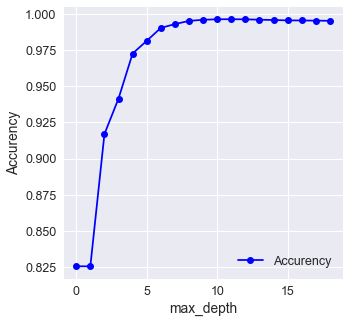

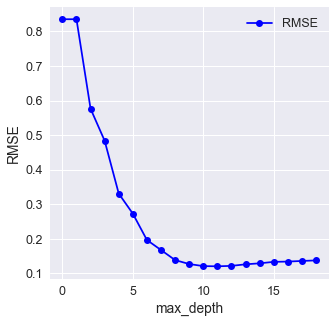

In [28]:
%%time
decisionTreeArgumentOptimalization(featurse, label)

In [35]:
%%time
decisionTree(featurse, label, depth=11)

[DecisionTree] Accurency of the best configuration: 0.9963825077002053
[DecisionTree] RMSE of the best configuration: 0.014469969199178645


In [36]:
%%time
randomForestArgumentOptimalization(featurse, label)

[0.9973049281314168, 16, 401, 6]
[0.10382816320407796, 16, 401, 6]


In [39]:
%%time
gradientBoosting(featurse, label)

[DecisionTree] Accuracy of the best configuration: 0.9951419190622861
[DecisionTree] RMSE of the best configuration: 0.019432323750855577
